# Packages

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats


from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, FunctionTransformer
from sklearn import linear_model


In [13]:
# !pip install pipelinehelper
from pipelinehelper import PipelineHelper

# Arguments and User Defined Functions

In [29]:
a = pd.read_csv("../outputs/bert_scores.csv")
a.shape

(565, 4)

In [14]:
# Dataframe that contains X, Y, (and other information)
data = pd.read_csv("../outputs/summary_data.csv")

# Drop any records with nulls
data = data.loc[
    ~data.isnull().any(axis=1),
]

# Columns that will not be used to generate features
non_features = [
    'file', 'line','start','end','speaker','speaker_role',"gs_score", 'text', 'start_idx', 'end_idx', 'year',
    "justice_gs_score_mean", "justice_gs_score_std", "justice_year_gs_score_mean", "justice_year_gs_score_std",
]

# Subset features to those not in the list above.
features = [x for x in data.columns if x not in non_features]


In [27]:
print(data.shape)

(17063, 110)


# Subselect and Split

In [15]:
X = data[features]
y = data["gs_score"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)

# Models

## Pipelines & Parameters Options

In [18]:
pipe = Pipeline(
    [
        (
            "scaler",
            PipelineHelper(
                [
                    ("std", StandardScaler()),
                    ("none", FunctionTransformer(lambda x: x)), # No scaling
                ]
            ),
        ),
        (
            "regressors",
            PipelineHelper(
                [
                    ("elastic", linear_model.ElasticNet()),
                    ("gradient_boosting", ensemble.GradientBoostingRegressor()),
                    ("random_forest", ensemble.RandomForestRegressor())
                ]
            ),
        ),
    ]
)


params = {
    "scaler__selected_model": pipe.named_steps["scaler"].generate(
        {
            "std__with_mean": [True],
            "std__with_std": [True],
        }
    ),
    "regressors__selected_model": pipe.named_steps["regressors"].generate(
        {
            "elastic__l1_ratio": [1],
            "elastic__alpha": [0.01],
            "gradient_boosting__n_estimators": [200],
            "gradient_boosting__max_depth": [3],
            "gradient_boosting__min_samples_split": [64],
            "gradient_boosting__learning_rate": [0.1],
            "gradient_boosting__max_features": ["sqrt"],
            "random_forest__max_depth": [10],
            "random_forest__n_estimators": [1000],
        }
    ),
}

## Fitting

In [26]:
grid = GridSearchCV(pipe, params, scoring="neg_mean_squared_error", verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e+00, tolerance: 5.374e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.775e+00, tolerance: 5.429e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

KeyboardInterrupt: 

In [ ]:
print(grid.best_params_)
print(grid.best_score_)
mse = mean_squared_error(y_test, grid.predict(X_test))
r2 = r2_score(y_test, grid.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The R-squared (R2) on test set: {:.4f}".format(r2))

{'regressors__selected_model': ('random_forest', {'max_depth': 10, 'n_estimators': 1000}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}
-0.3201699611471769
The mean squared error (MSE) on test set: 0.1093
The R-squared (R2) on test set: 0.7380


## Prediction Analysis

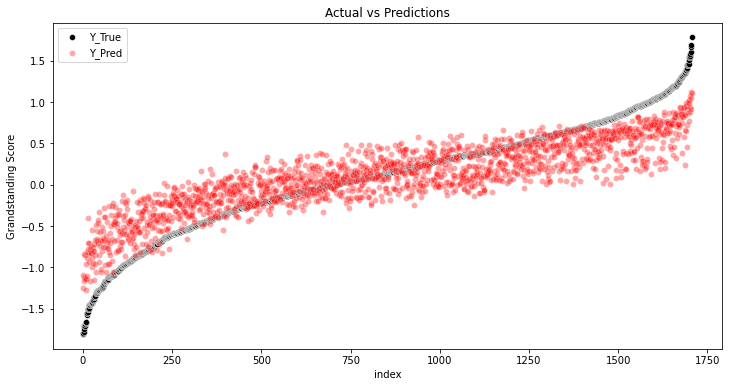

In [ ]:
preds = grid.predict(X_test)
pred_df = pd.DataFrame(data={"y_true": y_test, "y_pred": preds})

pred_df = pred_df.sort_values("y_true").reset_index(drop=True)
pred_df = pred_df.reset_index(drop=False)

figure, ax = plt.subplots(ncols=1, figsize=(12, 6))
g = sns.scatterplot(
    x="index", y="y_true", data=pred_df, alpha=1, label="Y_True", color="k"
)
g = sns.scatterplot(
    x="index", y="y_pred", data=pred_df, alpha=0.35, label="Y_Pred", color="red"
)
plt.title("Actual vs Predictions")
plt.ylabel("Grandstanding Score")
plt.show()

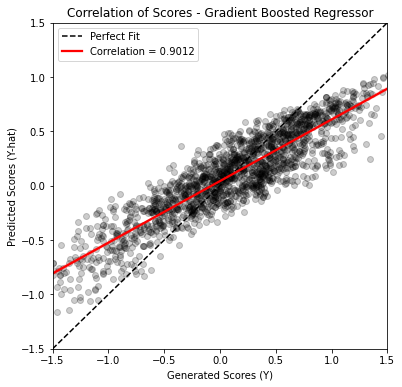

In [ ]:
corr_ = stats.pearsonr(pred_df["y_true"], pred_df["y_pred"])

plt.figure(figsize=(6, 6))
plt.plot([-1.5, 1.5], [-1.5, 1.5], linestyle="--", color="k", label="Perfect Fit")

g = sns.regplot(
    x="y_true",
    y="y_pred",
    data=pred_df,
    scatter_kws={"color": "black", "alpha": 0.2},
    line_kws={"color": "red", "label": f"Correlation = {round(corr_[0],4)}"},
)


g.set(ylim=(-1.5, 1.5))
g.set(xlim=(-1.5, 1.5))
g.set(xlabel="Generated Scores (Y)")
g.set(ylabel="Predicted Scores (Y-hat)")
g.set(title=("Correlation of Scores - Gradient Boosted Regressor"))
g.legend()

C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(336.9714285714286, 0.5, 'Predicted Scores (Y-hat)')]

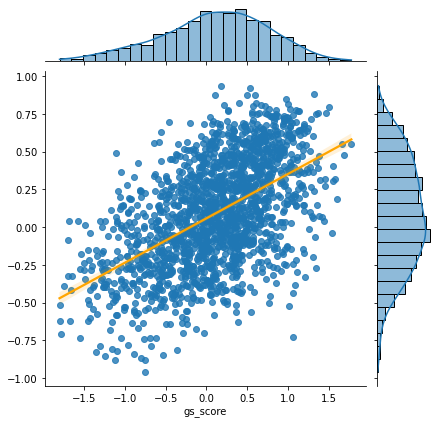

In [ ]:
g = sns.jointplot(
    y_test,
    reg.predict(X_test),
    kind="reg",
    joint_kws={"line_kws": {"color": "orange", "label": "Correlation = 0.5349"}},
)
ax = plt.gca()
ax.set(xlabel="Generated Scores (Y)")
ax.set(ylabel="Predicted Scores (Y-hat)")